

# Hungary Growth Accounting

**This report was generated using AI under general human direction. At the time of generation, the contents have not been comprehensively reviewed by a human analyst.**

## (a) Setup & Data Loading



In [1]:
library(tidyverse)
library(readxl)

# ── Helper: read an Excel sheet from the national / capital accounts ──────────
# All Excel sheets are in wide format: one row per sector, columns = years.
# This helper pivots them to long format.
read_euklems_sheet <- function(path, sheet) {
  read_excel(path, sheet = sheet) |>
    select(-any_of(c("var", "geo_code", "geo_name"))) |>
    pivot_longer(
      cols = matches("^\\d{4}$"),
      names_to  = "year",
      values_to = sheet
    ) |>
    mutate(year = as.integer(year))
}

# ── National accounts ─────────────────────────────────────────────────────────
na_path  <- "HU_national_accounts.xlsx"
cap_path <- "HU_capital_accounts.xlsx"

va_q   <- read_euklems_sheet(na_path, "VA_Q")      # real value added (volume index)
va_cp  <- read_euklems_sheet(na_path, "VA_CP")      # nominal value added
comp   <- read_euklems_sheet(na_path, "COMP")        # compensation of employees
h_emp  <- read_euklems_sheet(na_path, "H_EMP")       # total hours worked (employees)
emp    <- read_euklems_sheet(na_path, "EMP")          # persons employed
kq     <- read_euklems_sheet(cap_path, "Kq_GFCF")    # real capital stock (quality-adjusted)

# Merge into a single long panel
panel <- va_q |>
  left_join(va_cp, by = c("nace_r2_code", "nace_r2_name", "year")) |>
  left_join(comp,  by = c("nace_r2_code", "nace_r2_name", "year")) |>
  left_join(h_emp, by = c("nace_r2_code", "nace_r2_name", "year")) |>
  left_join(emp,   by = c("nace_r2_code", "nace_r2_name", "year")) |>
  left_join(kq,    by = c("nace_r2_code", "nace_r2_name", "year"))

# ── Growth accounts CSV (for LP1 pre-computed variables where available) ──────
ga_raw <- read_csv(
  "growth_accounts.csv",
  col_types = cols(
    .default     = col_character(),
    year         = col_integer(),
    value        = col_double()
  )
) |>
  select(-1)   # drop the unnamed row-number column (...1)

hu_ga <- ga_raw |>
  filter(geo_code == "HU") |>
  select(nace_r2_code, year, var, value) |>
  pivot_wider(names_from = var, values_from = value)

# ── Define broad sectors ──────────────────────────────────────────────────────
# Note: EUKLEMS for Hungary has O-Q and R-S, not a single O-U aggregate.
broad_sectors <- c("A", "B", "C", "D-E", "F", "G", "H", "I", "J", "K",
                   "L", "M-N", "O-Q", "R-S")

panel_broad <- panel |> filter(nace_r2_code %in% broad_sectors)
panel_tot   <- panel |> filter(nace_r2_code == "TOT")


── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.2.0     ✔ readr     2.1.6
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.1     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the ]8;;http://conflicted.r-lib.org/conflicted package]8;; to force all conflicts to become errors


Warning messages:
1: package ‘tibble’ was built under R version 4.5.2 
2: package ‘readr’ was built under R version 4.5.2 
3: package ‘purrr’ was built under R version 4.5.2 
4: package ‘dplyr’ was built under R version 4.5.2 


New names:
• `` -> `...1`



## (b) Output per Worker — Aggregate



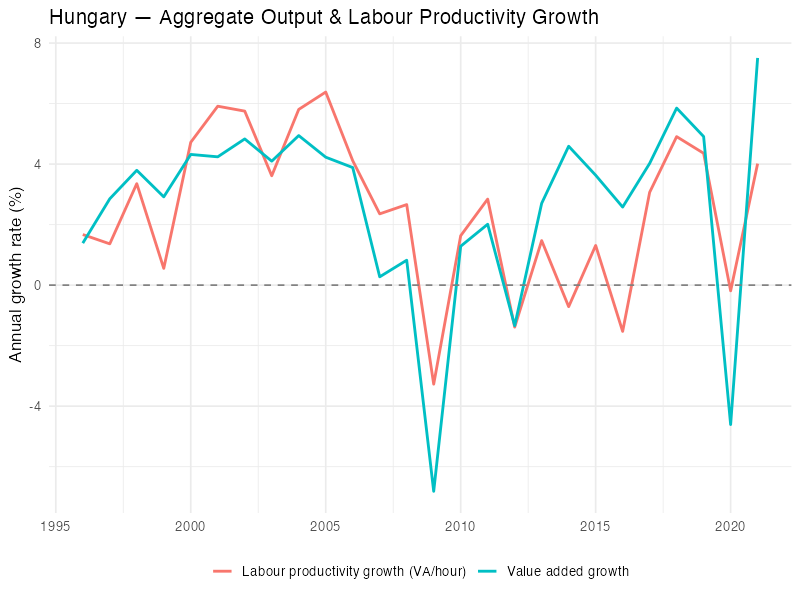

In [2]:
# Compute output per worker (real VA / total hours) and its growth rate
agg <- panel_tot |>
  arrange(year) |>
  mutate(
    y_per_hour = VA_Q / H_EMP,
    g_y        = (y_per_hour / lag(y_per_hour) - 1) * 100,
    g_va       = (VA_Q / lag(VA_Q) - 1) * 100
  )

agg |>
  filter(!is.na(g_y)) |>
  select(year, g_y, g_va) |>
  pivot_longer(-year, names_to = "series", values_to = "value") |>
  mutate(series = recode(series,
    g_y  = "Labour productivity growth (VA/hour)",
    g_va = "Value added growth"
  )) |>
  ggplot(aes(x = year, y = value, colour = series)) +
  geom_line(linewidth = 1) +
  geom_hline(yintercept = 0, linetype = "dashed", colour = "grey50") +
  labs(
    title = "Hungary — Aggregate Output & Labour Productivity Growth",
    x = NULL, y = "Annual growth rate (%)", colour = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "bottom")

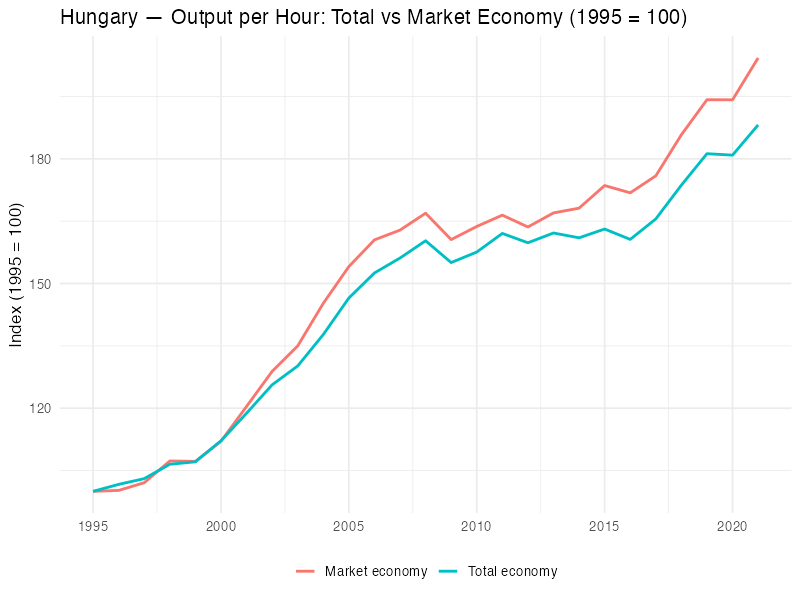

In [3]:
# Total economy vs market economy (MARKT)
panel_markt <- panel |> filter(nace_r2_code == "MARKT")

bind_rows(
  agg         |> mutate(economy = "Total economy",  y_per_hour = VA_Q / H_EMP),
  panel_markt |> mutate(economy = "Market economy", y_per_hour = VA_Q / H_EMP)
) |>
  group_by(economy) |>
  arrange(year) |>
  mutate(index = y_per_hour / first(y_per_hour) * 100) |>
  ungroup() |>
  ggplot(aes(x = year, y = index, colour = economy)) +
  geom_line(linewidth = 1) +
  labs(
    title = "Hungary — Output per Hour: Total vs Market Economy (1995 = 100)",
    x = NULL, y = "Index (1995 = 100)", colour = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "bottom")



## (c) Growth Decomposition — Aggregate (α = 1/3)

Using the formula from class:

$$y = \left(\frac{K}{Y}\right)^{\frac{\alpha}{1-\alpha}} h A$$

Taking log-differences:

$$\hat{y} = \frac{\alpha}{1-\alpha}\left(\hat{K} - \hat{Y}\right) + \hat{h} + \hat{A}$$

where $\hat{x}$ denotes log-growth of $x$.



In [4]:
alpha <- 1/3

# ── Aggregate decomposition ──────────────────────────────────────────────────
decomp_agg <- panel_tot |>
  arrange(year) |>
  mutate(
    # Output per hour
    y = VA_Q / H_EMP,
    # Capital-output ratio
    ky = Kq_GFCF / VA_Q,
    # Log-growth rates (× 100 for pp)
    g_y  = (log(y)        - log(lag(y)))        * 100,
    g_ky = (log(ky)       - log(lag(ky)))       * 100,
    # Capital deepening contribution: alpha/(1-alpha) * g(K/Y)
    cap_contrib = (alpha / (1 - alpha)) * g_ky
  )

# For human capital (h): use LAB_QI index from the growth accounts CSV
# LAB_QI is available 2008–2021 only
hu_ga_tot <- hu_ga |> filter(nace_r2_code == "TOT")

decomp_agg <- decomp_agg |>
  left_join(hu_ga_tot |> select(year, LAB_QI), by = "year") |>
  arrange(year) |>
  mutate(
    g_h          = (log(LAB_QI) - log(lag(LAB_QI))) * 100,
    hc_contrib   = g_h,
    # TFP as residual
    tfp_contrib  = g_y - cap_contrib - hc_contrib,
    total_growth = g_y
  )

decomp_agg |> select(year, total_growth, cap_contrib, hc_contrib, tfp_contrib)

# A tibble: 27 × 5
    year total_growth cap_contrib hc_contrib tfp_contrib
   <int>        <dbl>       <dbl>      <dbl>       <dbl>
 1  1995       NA          NA             NA          NA
 2  1996        1.66       -0.228         NA          NA
 3  1997        1.36       -0.618         NA          NA
 4  1998        3.30       -1.10          NA          NA
 5  1999        0.552      -0.402         NA          NA
 6  2000        4.61       -1.50          NA          NA
 7  2001        5.75       -1.19          NA          NA
 8  2002        5.59       -1.40          NA          NA
 9  2003        3.55       -1.25          NA          NA
10  2004        5.64       -1.45          NA          NA
# ℹ 17 more rows
# ℹ Use `print(n = ...)` to see more rows

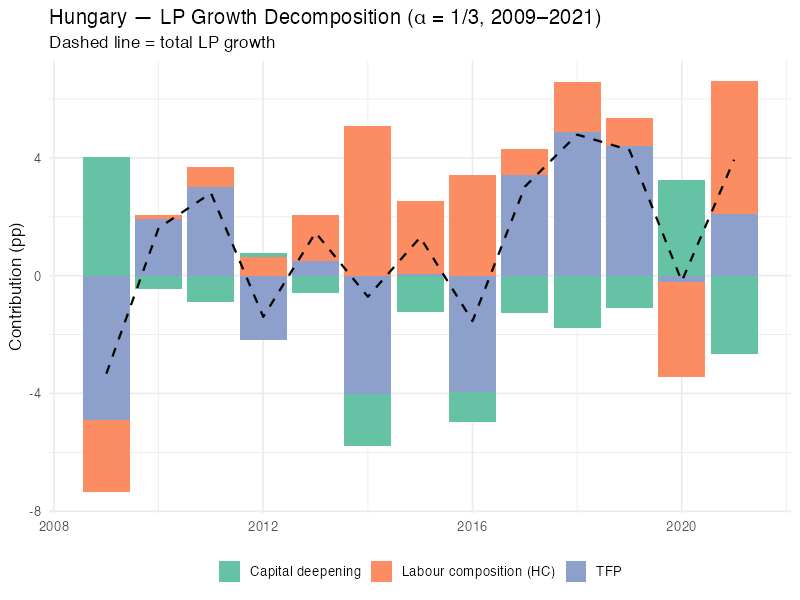

In [5]:
# Stacked bar decomposition (2009–2021 where all components are available)
decomp_agg_plot <- decomp_agg |>
  filter(!is.na(tfp_contrib))

decomp_agg_plot |>
  pivot_longer(
    cols = c(cap_contrib, hc_contrib, tfp_contrib),
    names_to = "component", values_to = "contribution"
  ) |>
  mutate(component = recode(component,
    cap_contrib = "Capital deepening",
    hc_contrib  = "Labour composition (HC)",
    tfp_contrib = "TFP"
  )) |>
  ggplot(aes(x = year, y = contribution, fill = component)) +
  geom_col(position = "stack") +
  geom_line(
    data = decomp_agg_plot,
    aes(x = year, y = total_growth),
    inherit.aes = FALSE,
    colour = "black", linewidth = 0.8, linetype = "dashed"
  ) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Hungary — LP Growth Decomposition (α = 1/3, 2009–2021)",
    subtitle = "Dashed line = total LP growth",
    x = NULL, y = "Contribution (pp)", fill = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "bottom")

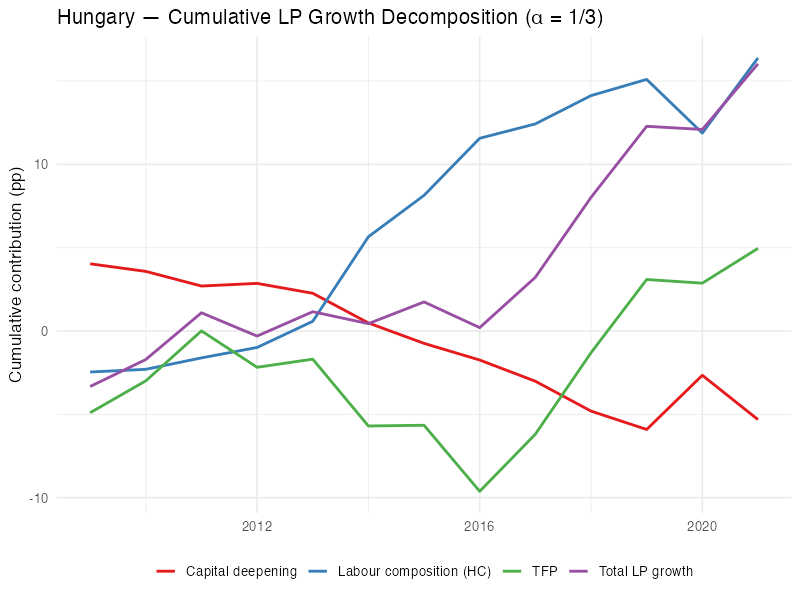

In [6]:
# Cumulative decomposition
decomp_agg_plot |>
  arrange(year) |>
  mutate(across(c(cap_contrib, hc_contrib, tfp_contrib, total_growth),
                cumsum, .names = "cum_{.col}")) |>
  pivot_longer(
    cols = starts_with("cum_"),
    names_to  = "component",
    values_to = "cumulative"
  ) |>
  mutate(component = recode(component,
    cum_cap_contrib  = "Capital deepening",
    cum_hc_contrib   = "Labour composition (HC)",
    cum_tfp_contrib  = "TFP",
    cum_total_growth = "Total LP growth"
  )) |>
  ggplot(aes(x = year, y = cumulative, colour = component)) +
  geom_line(linewidth = 1) +
  scale_colour_brewer(palette = "Set1") +
  labs(
    title = "Hungary — Cumulative LP Growth Decomposition (α = 1/3)",
    x = NULL, y = "Cumulative contribution (pp)", colour = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "bottom")

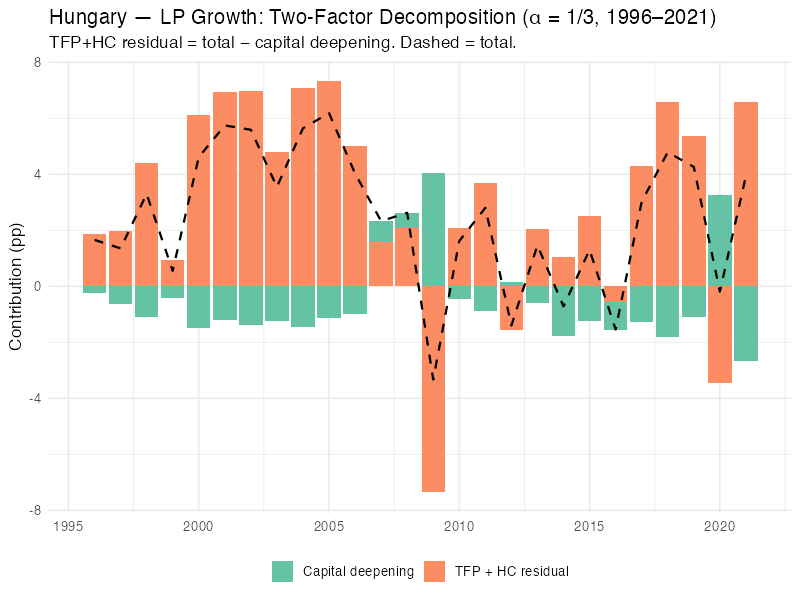

In [7]:
# Alternative: two-factor decomposition (capital + TFP residual) for full period 1996–2021
decomp_agg_2f <- decomp_agg |>
  filter(!is.na(g_y)) |>
  mutate(tfp_residual_2f = g_y - cap_contrib)

decomp_agg_2f |>
  pivot_longer(
    cols = c(cap_contrib, tfp_residual_2f),
    names_to = "component", values_to = "contribution"
  ) |>
  mutate(component = recode(component,
    cap_contrib      = "Capital deepening",
    tfp_residual_2f  = "TFP + HC residual"
  )) |>
  ggplot(aes(x = year, y = contribution, fill = component)) +
  geom_col(position = "stack") +
  geom_line(
    data = decomp_agg_2f,
    aes(x = year, y = total_growth),
    inherit.aes = FALSE,
    colour = "black", linewidth = 0.8, linetype = "dashed"
  ) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Hungary — LP Growth: Two-Factor Decomposition (α = 1/3, 1996–2021)",
    subtitle = "TFP+HC residual = total − capital deepening. Dashed = total.",
    x = NULL, y = "Contribution (pp)", fill = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "bottom")


## (d) Sectoral Growth Decomposition



In [8]:
# Compute decomposition for each broad sector
decomp_sect <- panel_broad |>
  group_by(nace_r2_code, nace_r2_name) |>
  arrange(year) |>
  mutate(
    y  = VA_Q / H_EMP,
    ky = Kq_GFCF / VA_Q,
    g_y  = (log(y)  - log(lag(y)))  * 100,
    g_ky = (log(ky) - log(lag(ky))) * 100,
    cap_contrib = (alpha / (1 - alpha)) * g_ky
  ) |>
  ungroup()

# Join LAB_QI for human capital
hu_ga_broad <- hu_ga |>
  filter(nace_r2_code %in% broad_sectors) |>
  select(nace_r2_code, year, LAB_QI)

decomp_sect <- decomp_sect |>
  left_join(hu_ga_broad, by = c("nace_r2_code", "year")) |>
  group_by(nace_r2_code) |>
  arrange(year) |>
  mutate(
    g_h         = (log(LAB_QI) - log(lag(LAB_QI))) * 100,
    hc_contrib  = g_h,
    tfp_contrib = g_y - cap_contrib - hc_contrib,
    total_growth = g_y
  ) |>
  ungroup()

# Average annual contributions per sector (full three-factor: 2009–2021)
sect_avg_3f <- decomp_sect |>
  filter(!is.na(tfp_contrib)) |>
  group_by(nace_r2_code, nace_r2_name) |>
  summarise(across(c(cap_contrib, hc_contrib, tfp_contrib, total_growth),
                   \(x) mean(x, na.rm = TRUE)),
            .groups = "drop") |>
  arrange(desc(total_growth))

sect_avg_3f

# A tibble: 14 × 6
   nace_r2_code nace_r2_name                                                                            cap_contrib hc_contrib tfp_contrib total_growth
   <chr>        <chr>                                                                                         <dbl>      <dbl>       <dbl>        <dbl>
 1 B            Mining and quarrying                                                                         -3.36      -1.25       14.8         10.2  
 2 K            Financial and insurance activities                                                           -0.799      0.146       3.64         2.99 
 3 G            Wholesale and retail trade; repair of motor vehicles and motorcycles                         -0.550      0.433       2.77         2.66 
 4 J            Information and communication                                                                -3.24       5.03        0.258        2.05 
 5 L            Real estate activities                               

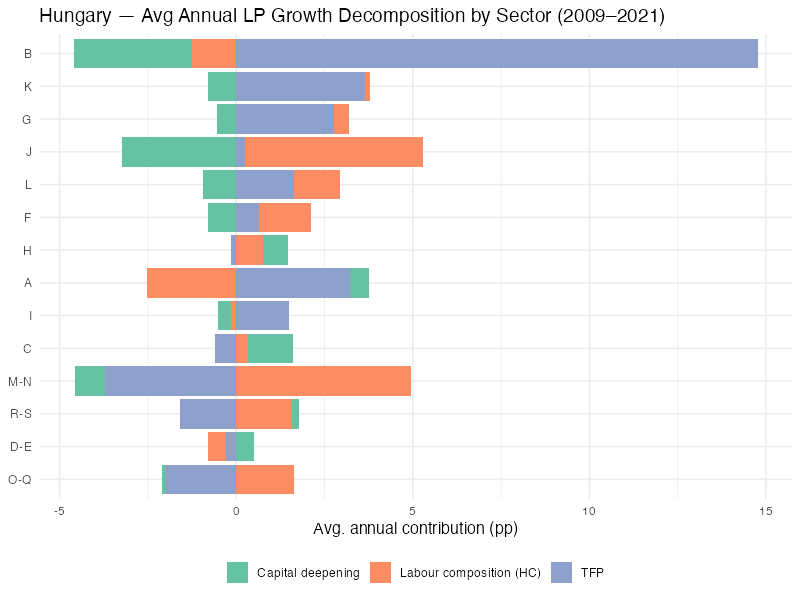

In [9]:
# Bar chart: average LP growth by sector (three-factor, 2009–2021)
sect_avg_3f |>
  mutate(nace_r2_code = fct_reorder(nace_r2_code, total_growth)) |>
  pivot_longer(
    cols = c(cap_contrib, hc_contrib, tfp_contrib),
    names_to = "component", values_to = "contribution"
  ) |>
  mutate(component = recode(component,
    cap_contrib = "Capital deepening",
    hc_contrib  = "Labour composition (HC)",
    tfp_contrib = "TFP"
  )) |>
  ggplot(aes(x = nace_r2_code, y = contribution, fill = component)) +
  geom_col(position = "stack") +
  coord_flip() +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Hungary — Avg Annual LP Growth Decomposition by Sector (2009–2021)",
    x = NULL, y = "Avg. annual contribution (pp)", fill = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom")

In [10]:
# Highest and lowest: output per worker growth & TFP (two-factor over full period)
sect_avg_2f <- decomp_sect |>
  filter(!is.na(g_y)) |>
  mutate(tfp_residual_2f = g_y - cap_contrib) |>
  group_by(nace_r2_code, nace_r2_name) |>
  summarise(
    total_growth    = mean(g_y, na.rm = TRUE),
    cap_contrib     = mean(cap_contrib, na.rm = TRUE),
    tfp_residual_2f = mean(tfp_residual_2f, na.rm = TRUE),
    .groups = "drop"
  ) |>
  arrange(desc(total_growth))

cat("=== Highest LP growth (1996–2021 average) ===\n")
sect_avg_2f |> slice_max(total_growth, n = 3) |>
  select(nace_r2_code, nace_r2_name, total_growth) |> print()

cat("\n=== Lowest LP growth ===\n")
sect_avg_2f |> slice_min(total_growth, n = 3) |>
  select(nace_r2_code, nace_r2_name, total_growth) |> print()

cat("\n=== Highest TFP+HC residual growth ===\n")
sect_avg_2f |> slice_max(tfp_residual_2f, n = 3) |>
  select(nace_r2_code, nace_r2_name, tfp_residual_2f) |> print()

cat("\n=== Lowest TFP+HC residual growth ===\n")
sect_avg_2f |> slice_min(tfp_residual_2f, n = 3) |>
  select(nace_r2_code, nace_r2_name, tfp_residual_2f) |> print()

=== Highest LP growth (1996–2021 average) ===
# A tibble: 3 × 3
  nace_r2_code nace_r2_name                      total_growth
  <chr>        <chr>                                    <dbl>
1 B            Mining and quarrying                     10.7 
2 A            Agriculture, forestry and fishing         4.98
3 J            Information and communication             3.98

=== Lowest LP growth ===
# A tibble: 3 × 3
  nace_r2_code nace_r2_name                                                                                     total_growth
  <chr>        <chr>                                                                                                   <dbl>
1 M-N          Professional, scientific and technical activities; administrative and support service activities       -0.462
2 K            Financial and insurance activities                                                                     -0.387
3 I            Accommodation and food service activities                          

In [11]:
# Three-factor rankings (2009–2021 only, where LAB_QI is available)
cat("=== Highest TFP growth (2009–2021) ===\n")
sect_avg_3f |> slice_max(tfp_contrib, n = 3) |>
  select(nace_r2_code, nace_r2_name, tfp_contrib) |> print()

cat("\n=== Lowest TFP growth (2009–2021) ===\n")
sect_avg_3f |> slice_min(tfp_contrib, n = 3) |>
  select(nace_r2_code, nace_r2_name, tfp_contrib) |> print()

=== Highest TFP growth (2009–2021) ===
# A tibble: 3 × 3
  nace_r2_code nace_r2_name                       tfp_contrib
  <chr>        <chr>                                    <dbl>
1 B            Mining and quarrying                     14.8 
2 K            Financial and insurance activities        3.64
3 A            Agriculture, forestry and fishing         3.22

=== Lowest TFP growth (2009–2021) ===
# A tibble: 3 × 3
  nace_r2_code nace_r2_name                                                                                     tfp_contrib
  <chr>        <chr>                                                                                                  <dbl>
1 M-N          Professional, scientific and technical activities; administrative and support service activities       -3.70
2 O-Q          Public administration, defence, education, human health and social work activities                     -1.98
3 R-S          Arts, entertainment, recreation; other services and service activ


## (e) Labour Share & Sector-Specific α



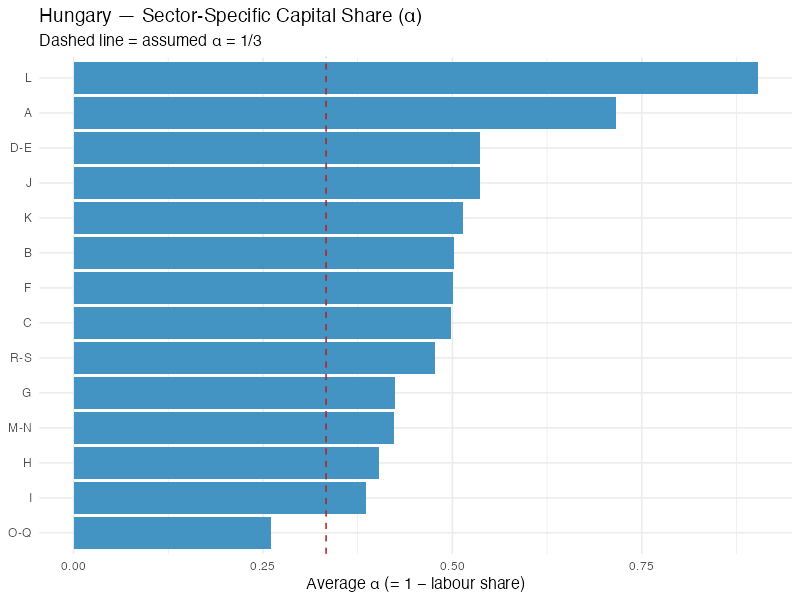

In [12]:
# Labour share = COMP / VA_CP for each sector-year
# (1 - alpha_s) = labour share  =>  alpha_s = 1 - labour_share
sector_shares <- panel_broad |>
  mutate(
    labour_share = COMP / VA_CP,
    alpha_s      = 1 - labour_share
  ) |>
  select(nace_r2_code, nace_r2_name, year, labour_share, alpha_s)

# Average alpha per sector
alpha_by_sect <- sector_shares |>
  group_by(nace_r2_code, nace_r2_name) |>
  summarise(
    avg_labour_share = mean(labour_share, na.rm = TRUE),
    avg_alpha        = mean(alpha_s, na.rm = TRUE),
    .groups = "drop"
  )

alpha_by_sect |>
  ggplot(aes(x = fct_reorder(nace_r2_code, avg_alpha), y = avg_alpha)) +
  geom_col(fill = "#4393c3") +
  geom_hline(yintercept = 1/3, linetype = "dashed", colour = "firebrick") +
  coord_flip() +
  labs(
    title = "Hungary — Sector-Specific Capital Share (α)",
    subtitle = "Dashed line = assumed α = 1/3",
    x = NULL, y = "Average α (= 1 − labour share)"
  ) +
  theme_minimal(base_size = 12)

In [13]:
# Redo decomposition with sector-specific alpha
decomp_sect_alpha <- panel_broad |>
  left_join(alpha_by_sect |> select(nace_r2_code, avg_alpha), by = "nace_r2_code") |>
  group_by(nace_r2_code, nace_r2_name) |>
  arrange(year) |>
  mutate(
    y  = VA_Q / H_EMP,
    ky = Kq_GFCF / VA_Q,
    g_y  = (log(y)  - log(lag(y)))  * 100,
    g_ky = (log(ky) - log(lag(ky))) * 100,
    cap_contrib_s = (avg_alpha / (1 - avg_alpha)) * g_ky
  ) |>
  ungroup() |>
  left_join(hu_ga_broad, by = c("nace_r2_code", "year")) |>
  group_by(nace_r2_code) |>
  arrange(year) |>
  mutate(
    g_h            = (log(LAB_QI) - log(lag(LAB_QI))) * 100,
    hc_contrib     = g_h,
    tfp_contrib_s  = g_y - cap_contrib_s - hc_contrib,
    total_growth   = g_y
  ) |>
  ungroup()

sect_avg_alpha <- decomp_sect_alpha |>
  filter(!is.na(tfp_contrib_s)) |>
  group_by(nace_r2_code, nace_r2_name) |>
  summarise(
    across(c(cap_contrib_s, hc_contrib, tfp_contrib_s, total_growth),
           \(x) mean(x, na.rm = TRUE)),
    avg_alpha = first(avg_alpha),
    .groups = "drop"
  ) |>
  arrange(desc(total_growth))

sect_avg_alpha

# A tibble: 14 × 7
   nace_r2_code nace_r2_name                                                              cap_contrib_s hc_contrib tfp_contrib_s total_growth avg_alpha
   <chr>        <chr>                                                                             <dbl>      <dbl>         <dbl>        <dbl>     <dbl>
 1 B            Mining and quarrying                                                            -6.79       -1.25         18.2         10.2       0.503
 2 K            Financial and insurance activities                                              -1.69        0.146         4.53         2.99      0.513
 3 G            Wholesale and retail trade; repair of motor vehicles and motorcycles            -0.809       0.433         3.03         2.66      0.424
 4 J            Information and communication                                                   -7.50        5.03          4.52         2.05      0.537
 5 L            Real estate activities                               

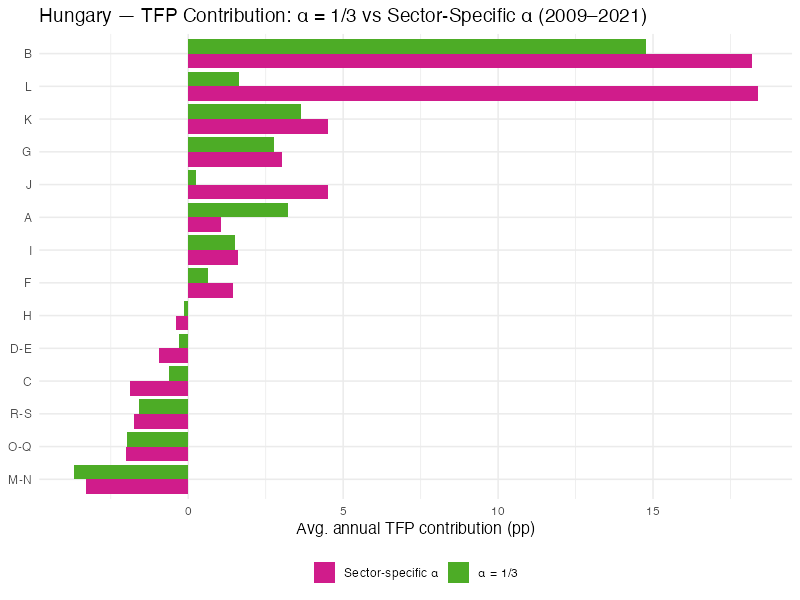

In [14]:
# Compare TFP: α = 1/3 vs sector-specific α (both over 2009–2021)
bind_rows(
  sect_avg_3f     |> mutate(assumption = "α = 1/3",            tfp = tfp_contrib),
  sect_avg_alpha  |> mutate(assumption = "Sector-specific α",  tfp = tfp_contrib_s)
) |>
  select(nace_r2_code, assumption, tfp) |>
  ggplot(aes(x = fct_reorder(nace_r2_code, tfp), y = tfp, fill = assumption)) +
  geom_col(position = "dodge") +
  coord_flip() +
  scale_fill_manual(values = c("α = 1/3" = "#4dac26", "Sector-specific α" = "#d01c8b")) +
  labs(
    title = "Hungary — TFP Contribution: α = 1/3 vs Sector-Specific α (2009–2021)",
    x = NULL, y = "Avg. annual TFP contribution (pp)", fill = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom")


## (f) Aggregating from Sectoral Data



In [15]:
# Aggregate LP growth from sectoral data using value-added share weights
# w_s(t) = VA_CP_s(t) / sum_s VA_CP_s(t)

# Merge nominal VA shares with sectoral decomposition
sect_with_shares <- decomp_sect |>
  left_join(
    panel_broad |> select(nace_r2_code, year, VA_CP),
    by = c("nace_r2_code", "year")
  ) |>
  group_by(year) |>
  mutate(
    va_total  = sum(VA_CP, na.rm = TRUE),
    va_share  = VA_CP / va_total
  ) |>
  ungroup()

# Weighted aggregation (two-factor: full period)
agg_from_sectors <- sect_with_shares |>
  filter(!is.na(g_y)) |>
  mutate(tfp_residual_2f = g_y - cap_contrib) |>
  group_by(year) |>
  summarise(
    lp_sectoral  = sum(va_share * g_y,             na.rm = TRUE),
    cap_sectoral = sum(va_share * cap_contrib,      na.rm = TRUE),
    tfp_sectoral = sum(va_share * tfp_residual_2f,  na.rm = TRUE),
    .groups = "drop"
  )

# Compare with reported aggregate
comparison <- decomp_agg |>
  filter(!is.na(g_y)) |>
  select(year, lp_reported = total_growth, cap_reported = cap_contrib) |>
  mutate(tfp_reported = lp_reported - cap_reported) |>
  left_join(agg_from_sectors, by = "year")

comparison


: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `va_total = sum(VA_CP, na.rm = TRUE)`.
[36mℹ[39m In group 1: `year = 1995`.
[1mCaused by error:[22m
[33m![39m object 'VA_CP' not found

In [ ]:
# Plot reported vs sector-aggregated LP growth
comparison |>
  select(year, lp_reported, lp_sectoral) |>
  pivot_longer(-year, names_to = "series", values_to = "value") |>
  mutate(series = recode(series,
    lp_reported  = "Reported aggregate",
    lp_sectoral  = "Aggregated from sectors"
  )) |>
  ggplot(aes(x = year, y = value, colour = series, linetype = series)) +
  geom_line(linewidth = 1) +
  scale_colour_manual(values = c("Reported aggregate" = "#1b7837",
                                  "Aggregated from sectors" = "#762a83")) +
  labs(
    title = "Hungary — Reported vs Sector-Aggregated LP Growth",
    x = NULL, y = "LP growth (pp)", colour = NULL, linetype = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "bottom")



## (g) Time Series by Sector — Policy Context



In [ ]:
# Heatmap of TFP+HC residual by sector and year (full period)
decomp_sect |>
  filter(!is.na(g_y)) |>
  mutate(tfp_residual_2f = g_y - cap_contrib) |>
  ggplot(aes(x = year, y = nace_r2_code, fill = tfp_residual_2f)) +
  geom_tile() +
  scale_fill_distiller(palette = "RdBu", direction = 1,
                       name = "TFP+HC\nresidual (pp)") +
  labs(
    title = "Hungary — Annual TFP+HC Residual by Sector (1996–2021)",
    x = NULL, y = "NACE sector"
  ) +
  theme_minimal(base_size = 12)

In [ ]:
# Highlight key periods
events <- tibble(
  year  = c(2004, 2008, 2010),
  label = c("EU accession", "GFC", "Orbán govt.")
)

decomp_agg |>
  filter(!is.na(g_y)) |>
  mutate(tfp_residual_2f = g_y - cap_contrib) |>
  select(year, total_growth, cap_contrib, tfp_residual_2f) |>
  pivot_longer(-year, names_to = "series", values_to = "value") |>
  mutate(series = recode(series,
    total_growth    = "LP growth",
    cap_contrib     = "Capital deepening",
    tfp_residual_2f = "TFP + HC residual"
  )) |>
  ggplot(aes(x = year, y = value, colour = series)) +
  geom_line(linewidth = 1) +
  geom_vline(data = events, aes(xintercept = year),
             linetype = "dotted", colour = "grey40") +
  geom_text(data = events, aes(x = year, y = Inf, label = label),
            inherit.aes = FALSE, angle = 90, vjust = 1.3, hjust = 1.1,
            size = 3, colour = "grey30") +
  scale_colour_brewer(palette = "Set1") +
  labs(
    title = "Hungary — LP Growth Decomposition with Key Policy Events",
    x = NULL, y = "(%)", colour = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "bottom")